In [2]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/27061
# 标题：【复现】A股日内动量效应（一）:半小时 涨跌幅间的规律

# 引入库
from jqdata import *

import pickle
import itertools  # 迭代器工具
import numpy as np
import pandas as pd
import prettytable as pt
import scipy.stats as st
import statsmodels.api as sm

import calendar  # 日历
import datetime as dt
from tqdm import *
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from IPython.core.display import HTML

# 画图
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as mg # 不规则子图
import matplotlib.dates as mdate
import seaborn as sns

# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

# 数据准备，数据处理及画图函数准备

**preprocessing**生成并处理后续所需基础数据
- **plot_data_box**画数据箱体图
- **plot_corr_table**画半小时收益相关性热力图
- **plot_ann_returns**画各个信号年化收益(多空)热力图
- **plot_cum**画信号净值曲线图

In [3]:
# 数据准备
def preprocessing(symbol: str, start_date: str, end_date: str):
    '''
    输入:指数代码,起始时间,截止时间 freq=30m
    =========
    return daily_returns,ret,Pos_corr(动量关系), Neg_corr(反转关系)
    '''
    # 获取数据体
    price_df = get_price(
        symbol,
        start_date + ' 9:30:00',
        end_date + ' 15:30:00',
        frequency='30m',
        fields='close')

    # 首个半小时为open
    open_df = get_price(
        symbol, start_date=start_date, end_date=end_date, fields='open')

    open_df.index = pd.to_datetime([str(i) + ' 9:30:00' for i in open_df.index])
    open_df.columns = ['close']

    price_open = price_df.append(open_df, sort=True).sort_index()
    price_open.index.names = ['time']

    ret_open = price_open.groupby(pd.Grouper(
        level='time', freq='D'))['close'].transform(lambda x: x.pct_change())

    ret_open = ret_open.to_frame('ret')

    f = [
        i.strftime('%H:%M:%S')
        if i.strftime('%H:%M') != "09:30" else i.strftime('%H:%M:%S') + '(Open)'
        for i in ret_open.index
    ]

    f_ = [i if i != "11:30:00" else '13:00:00' for i in ["0"] + f[:-1]]
    frequency = [x[0] + '-' + x[1] for x in zip(f_, f)]
    ret_open['frequency'] = frequency

    # 首个半小时为close
    pre_day = get_trade_days(end_date=start_date, count=1)[0]

    close_df = get_price(
        symbol, start_date=pre_day, end_date=end_date, fields='close')

    close_df.index = pd.to_datetime(
        [str(i) + ' 9:30:00' for i in close_df.index])

    close_df.index = close_df.index[1:].tolist() + [np.nan]
    close_df = close_df.iloc[:-1]
    close_df.columns = ['close']

    #price_close = price_df.append(close_df, sort=True).sort_index()
    price_close = price_df.at_time('10:00').append(
        close_df, sort=True).sort_index()
    price_close.index.names = ['time']

    ret_close = price_close.groupby(pd.Grouper(
        level='time', freq='D'))['close'].transform(lambda x: x.pct_change())

    ret_close = ret_close.to_frame('ret').dropna()
    ret_close['frequency'] = '09:30:00(Yclose)-10:00:00'

    dropna_ret = ret_open.dropna()

    # 最终构建出的数据
    ret = dropna_ret.append(
        ret_close.query('frequency=="09:30:00(Yclose)-10:00:00"'), sort=True)
    ret = ret.sort_index()

    #------------------------------------------------------------------------
    # 计算相关性
    ret['day'] = [i.strftime('%Y-%m-%d') for i in ret.index]
    corr_df = ret.pivot(index='day', columns='frequency').corr()
    # 负相关
    Neg_corr = corr_df.applymap(lambda x: x if x < 0 else np.nan)
    Neg_corr.columns = Neg_corr.columns.levels[1]
    Neg_corr = Neg_corr.reset_index(level=0, drop=True)
    # 正相关
    Pos_corr = corr_df.applymap(lambda x: x if x > 0 else np.nan)
    Pos_corr.columns = Pos_corr.columns.levels[1]
    Pos_corr = Pos_corr.reset_index(level=0, drop=True)

    #-------------------------------------------------------------------------

    # 计算当日收益
    def _GetDailyReturns(ser: pd.Series):
        if len(ser) > 0:
            return ser[-1] / ser - 1

    # 计算日收益率
    daily_returns = price_open.groupby(pd.Grouper(
        level='time', freq='D'))['close'].transform(_GetDailyReturns)

    return [daily_returns, ret, Pos_corr, Neg_corr]


# 画箱体图
def plot_data_box(df: pd.DataFrame, symbol: str):

    name = get_security_info(symbol).display_name
    mpl.rcParams['font.family'] = 'serif'
    plt.title(name + '半小时涨跌幅箱体图')
    sns.boxplot(x="ret", y="frequency", data=df)
    plt.ylabel('')
    plt.xlabel('')
    plt.show()


# 画相关性热力图
def plot_corr_table(Neg_corr: pd.DataFrame, Pos_corr: pd.DataFrame,
                    symbol: str):

    name = get_security_info(symbol).display_name
    mpl.rcParams['font.family'] = 'serif'
    fig = plt.figure(figsize=(22, 8))

    fig.add_subplot(1, 2, 1)
    plt.title(name+'反转关系热力图')
    sns.heatmap(Neg_corr, annot=True, fmt='.2%')
    plt.ylabel('')
    plt.xlabel('')
    fig.add_subplot(1, 2, 2)
    plt.title(name+'动量关系热力图')
    sns.heatmap(Pos_corr, annot=True, fmt='.2%')
    plt.ylabel('')
    plt.xlabel('')
    plt.show()


# 画日内动量/反转策略年化收益
def plot_ann_returns(ret: pd.DataFrame, daily_returns: pd.DataFrame,
                     symbol: str):

    name = get_security_info(symbol).display_name

    name_list = ret['frequency'].unique().tolist()

    ret['daily_returns'] = daily_returns.shift(1)

    # 计算年化收益率
    def _CalAnnReturns(returns_arr):
        cum = (1 + returns_arr).cumprod()
        return pow(cum[-1] / cum[0], 250 / len(cum)) - 1

    temp_list = []

    for x, y in itertools.product(name_list, name_list):
        if x != y:
            flag = np.where(ret.query('frequency==@x')['ret'] > 0, 1, -1)
            daily_ret = ret.query('frequency==@y')['daily_returns']
            temp_list.append([x, y, _CalAnnReturns(flag * daily_ret)])

    ann_ret = pd.DataFrame(
        temp_list, columns=['x', 'y', 'daily_returns']).pivot(
            index='x', columns='y')
    for i in range(len(ann_ret)):
        for j in range(i):
            ann_ret.iat[i, j] = np.nan

    ann_ret.columns = ann_ret.columns.levels[1]
    plt.figure(figsize=(10, 6))
    plt.title(name + '日内动量/反转策略年化收益')
    sns.heatmap(ann_ret, annot=True, fmt='.2%')
    plt.ylabel('')
    plt.xlabel('')
    plt.show()


# 画净值曲线
def plot_cum(ret: pd.DataFrame, daily_returns: pd.DataFrame, symbol: str,
             target: tuple):

    x = target[0]
    y = target[1]
    name = get_security_info(symbol).display_name
    ret['daily_returns'] = daily_returns.shift(1)

    # 获取多空开仓点
    flag = np.where(ret.query('frequency==@x')['ret'] > 0, 1, -1)
    daily_ret = ret.query('frequency==@y')['daily_returns']
    cum = (1 + flag * daily_ret).cumprod()

    start = min(ret.index).strftime('%Y-%m-%d')
    end = max(ret.index).strftime('%Y-%m-%d')
    index_price = get_price(symbol, start, end, fields='close', panel=False)

    plt.figure(figsize=(18, 8))

    plt.title(name + '({}/{})'.format(x, y))
    plt.plot(cum, label='策略净值', color='r')
    plt.plot(
        index_price['close'] / index_price['close'].iloc[0],
        ls='--',
        label=name)

    plt.show()


# 打印
def show_df(df):

    tb = pt.PrettyTable()
    tb.add_column(df.index.name, df.index.tolist())
    if isinstance(df, pd.DataFrame):
        for label, col in df.items():
            tb.add_column(str(label), col.values)
        print(tb)
    else:
        tb.add_column("", df.values)
        print(tb)

In [4]:
%%time
# 数据范围
start_date,end_date = '2014-01-01','2020-04-24'
# 指数
security_list = ['000300.XSHG','000905.XSHG','000001.XSHG','399001.XSHE']

data_dict = {}

for code in security_list:
    
    data_dict[code] = preprocessing(code,start_date,end_date)

CPU times: user 34.2 s, sys: 423 ms, total: 34.6 s
Wall time: 34.7 s


In [5]:
print('daily_return数据结构:')
show_df(data_dict['000300.XSHG'][0].head())

print('ret数据结构:')
show_df(data_dict['000300.XSHG'][1].head())

daily_return数据结构:
+---------------------+------------------------+
|         time        |                        |
+---------------------+------------------------+
| 2014-01-02 09:30:00 | -0.0006240773339415417 |
| 2014-01-02 10:00:00 |  0.001172787871993597  |
| 2014-01-02 10:30:00 |  0.002253146635818881  |
| 2014-01-02 11:00:00 |  0.001082143765601673  |
| 2014-01-02 11:30:00 | 0.0014145857592617883  |
+---------------------+------------------------+
ret数据结构:
+---------------------+---------------------------+-------------------------+------------+
|         time        |         frequency         |           ret           |    day     |
+---------------------+---------------------------+-------------------------+------------+
| 2014-01-02 10:00:00 |  09:30:00(Open)-10:00:00  |  -0.0017947603327836958 | 2014-01-02 |
| 2014-01-02 10:00:00 | 09:30:00(Yclose)-10:00:00 |   -0.00462225808251393  | 2014-01-02 |
| 2014-01-02 10:30:00 |     10:00:00-10:30:00     |  -0.0010779300294059269 |

# 日内动量介绍

Gao L等学者在Market intraday momentum中提到指数日内涨跌幅的一个有趣 现象，即开盘半个小时的涨跌幅可预测收盘半小时的涨跌幅，这一规律在标普 500、道琼斯指数，罗素 2000 等指数均成立。作者给出了两点可能的解释:
1. 基金再平衡的需求 
2. 信息反应不足。

日内的成交额呈现明显的U字型，开盘之初和临近收盘是一天的交易中最为重要的时段，显然交易量较大的时间段通常包含更多机会及信息传递。围绕二者关系的研究对理解市场显然具有较强的启发意义。

# A股主要指数半小时涨跌幅相关性测试


上述的日内动量是否在A股市场也成立、A股是否存在其特有的日内动量/反转关系？将每天的交易时段9:30-11:30,13:00-15:00以半个小时为间隔，分为8段，计算各段内的指数涨跌幅，各时段涨跌幅的箱体图如下(在计算首个半小时涨跌幅时基准可选昨收或今开，在下图中以 9:30-10：00(yclose)及 9:30-10:00(open)来标注。

数据范围:2014-01-01至2020-04-24

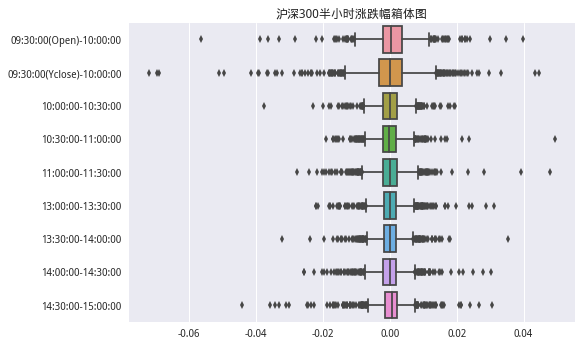

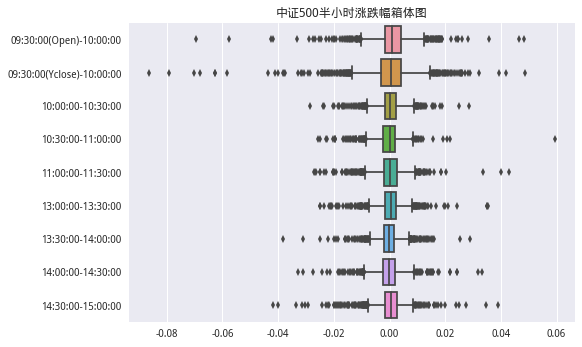

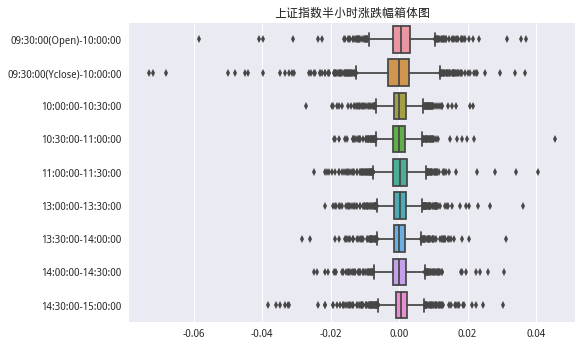

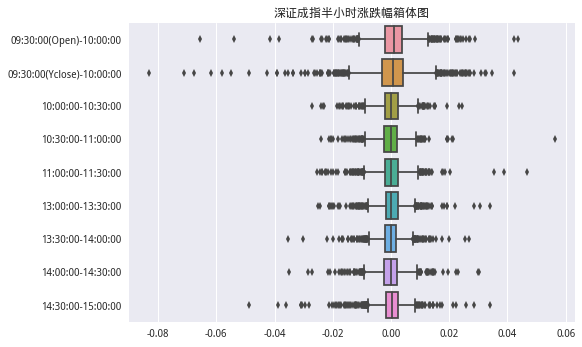

In [6]:
for code in security_list:

    plot_data_box(data_dict[code][1],code)

为了将日内动量和反转效应分别表示，双栏图左侧是只取相关系数<0 部分绘制 的热力图，颜色越深代表负相关性越强，右侧只取相关系数>0 部分绘制的热力图，颜色越深正相关系数越大。

1. 各指数在下午的交易时段，半小时涨跌幅之间呈现相对较强的正相关关系。 
2. 上午临收盘半个小时（11:00-11:30）与下午开盘半个小时(13:00-13:30)正 相关。 
3. 上午临收盘半个小时（11:00-11:30）与下午(13:30-14:00)负相关。 
4. 开盘后半个小时（9:30-10:00）与下午开盘后半个小时的涨跌幅(13:00-13:30) 正相关。 
5. 开盘后半个小时（9:30-10:00）与下午临收盘半个小时的涨跌幅(14:30-15:00)正相关。

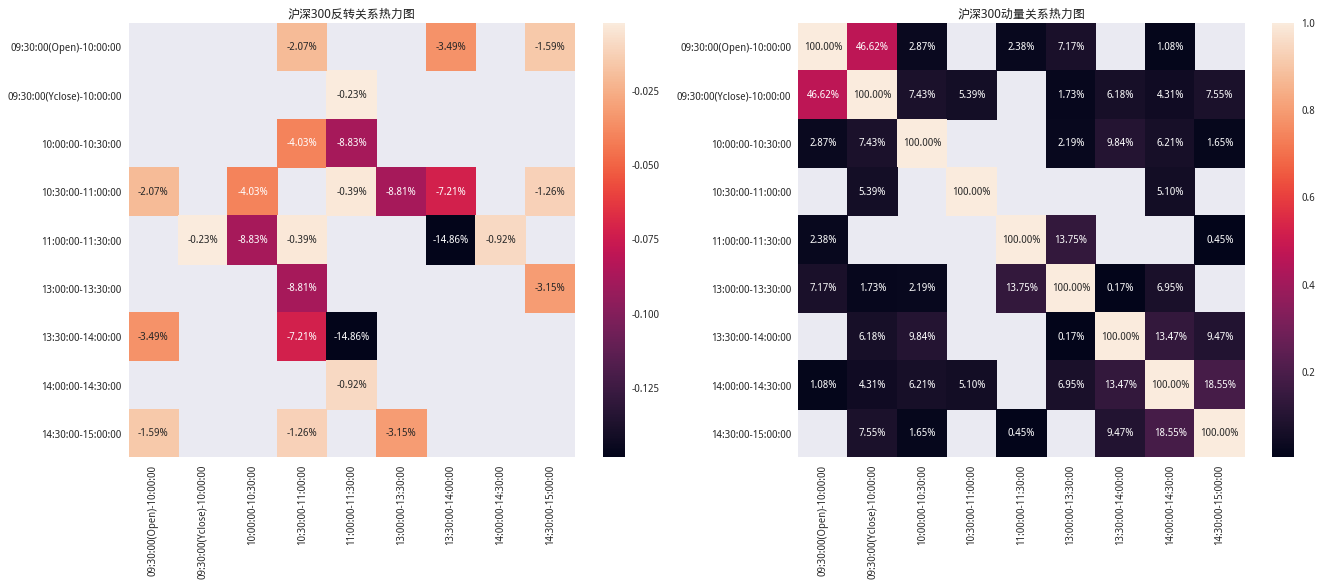

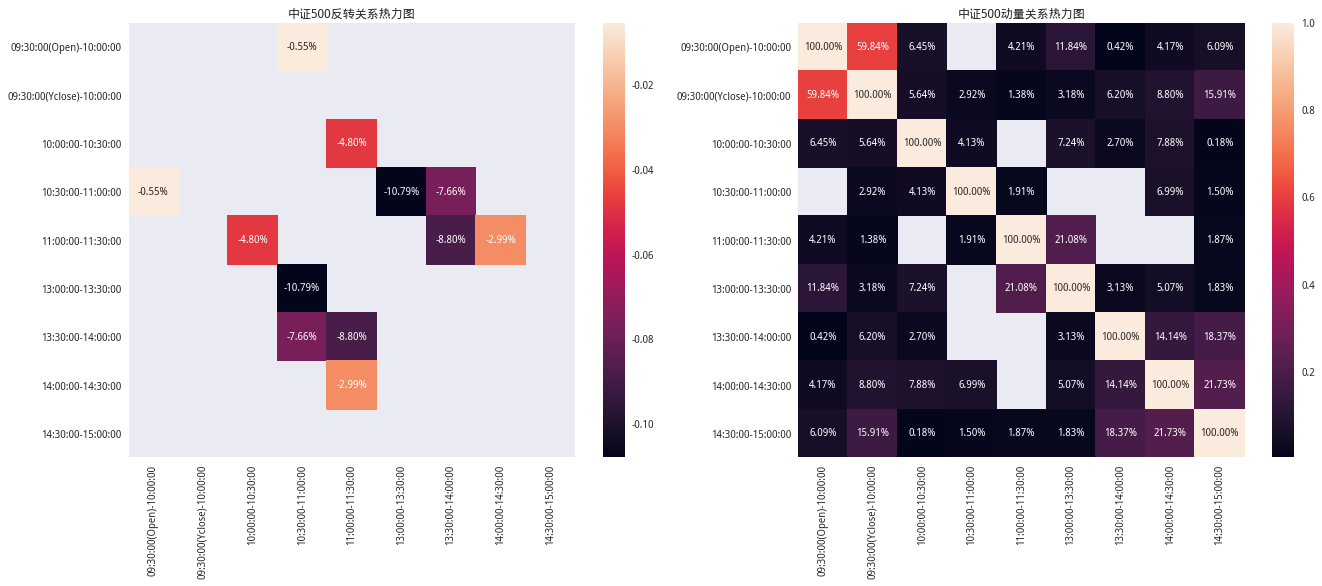

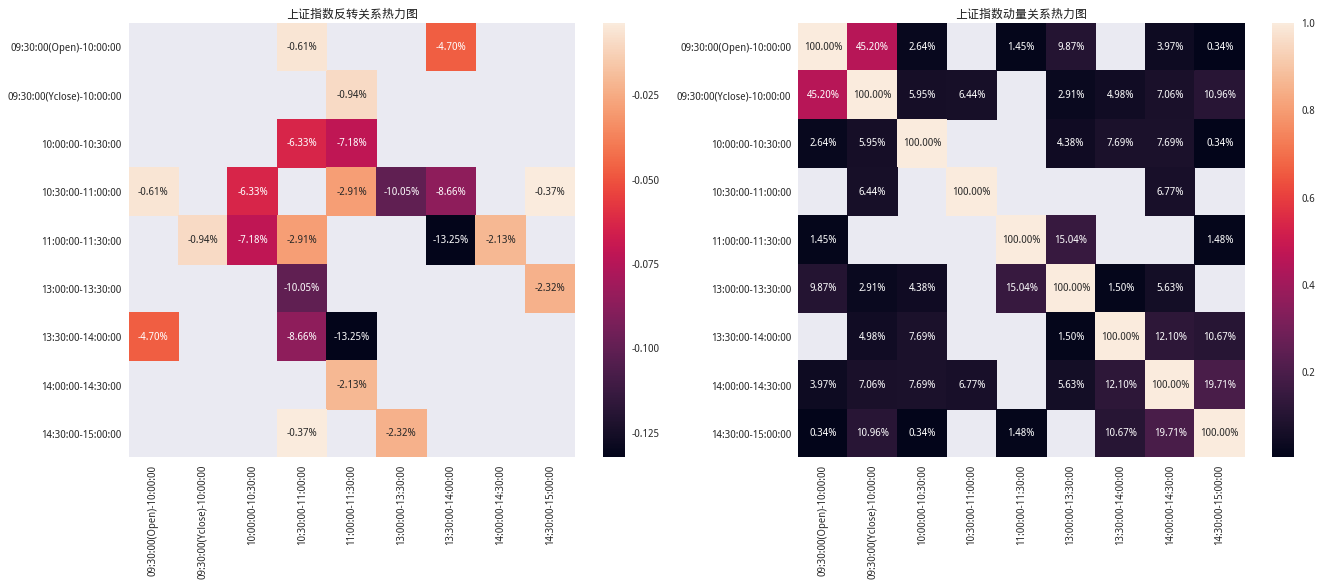

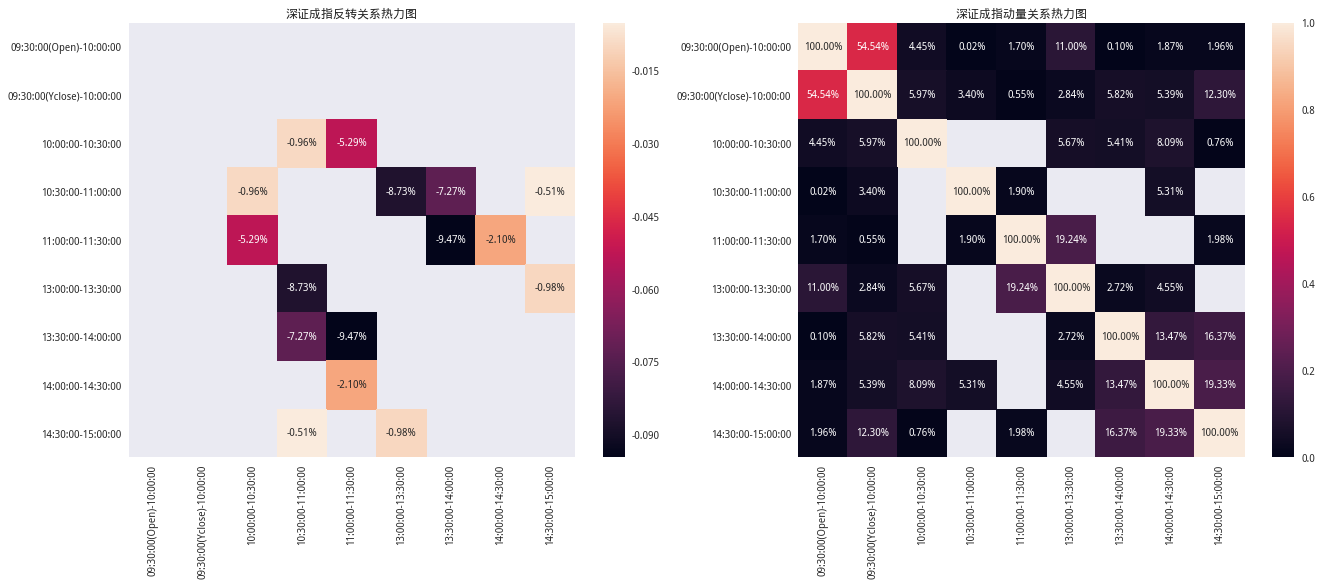

In [7]:
for code in security_list:

    plot_corr_table(data_dict[code][3],data_dict[code][2],code)

# 日内动量/反转策略

根据上一节结论，利用半小时涨跌幅之间的相关关系构造日内动量/反转策略。 若二者间关系为正相关，则构造动量策略，反之构造日内的反转策略，以某半小时的涨跌作为看多/看空的信号，指导同日另外某半小时的投资。2014-01-01至2020-04-24各种组合方式下的策略年化收益率。
其中深证成指与中证 500 日内动量 策略的效果较沪深 300 及上证综指更优。


1. 9:30-10:00(yclose)涨/跌，13:00-13:30 做多/空 
2. 9:30-10:00(yclose)涨/跌，14:30-15:00 做多/空 
3. 11:00-11:30 涨/跌，13:00-13:30 做多/空 
4. 13:30-14:00 涨/跌，14:00-14:30 做多/空
5. 14:00-14:30 涨/跌，14:30-15:00 做多/空

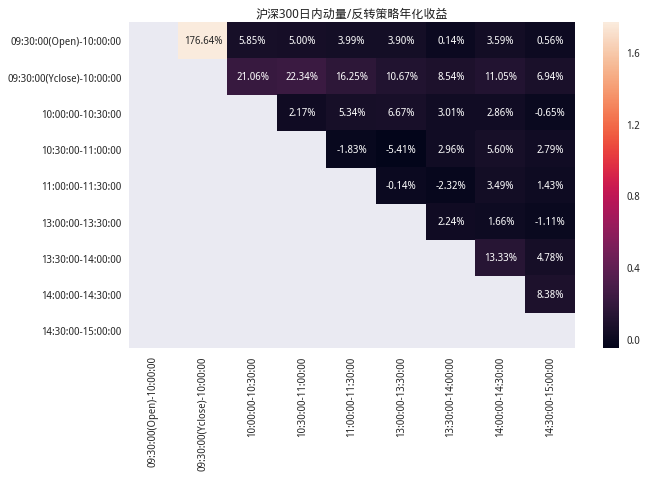

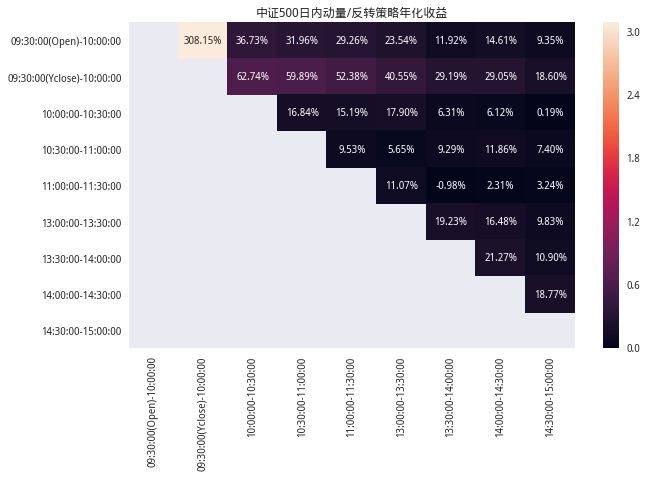

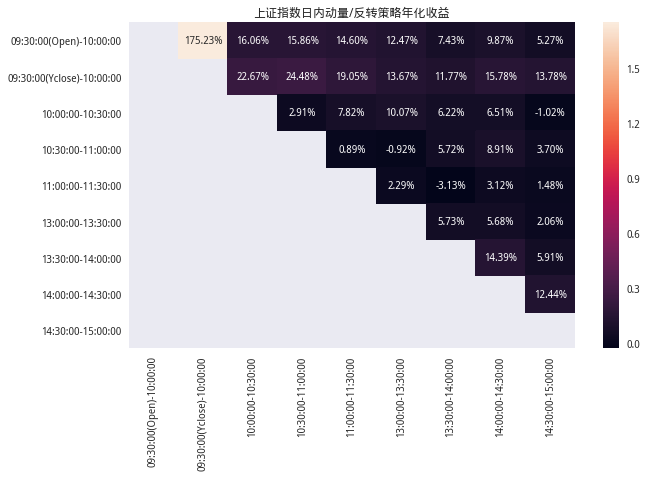

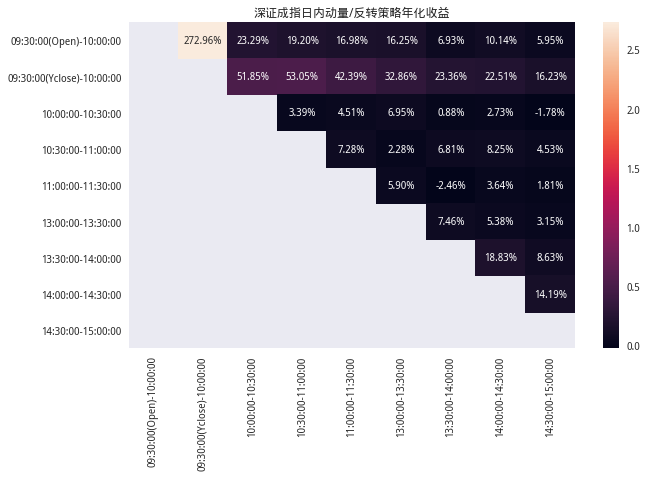

In [8]:
for code in security_list:
    plot_ann_returns(data_dict[code][1],data_dict[code][0],code)

# 策略汇总

策略一：若 9:30-10:00(yclose)指数涨/跌，则在13:00-13:30做多/空。日内交易，回测区间2014.1.1-2020.4.24

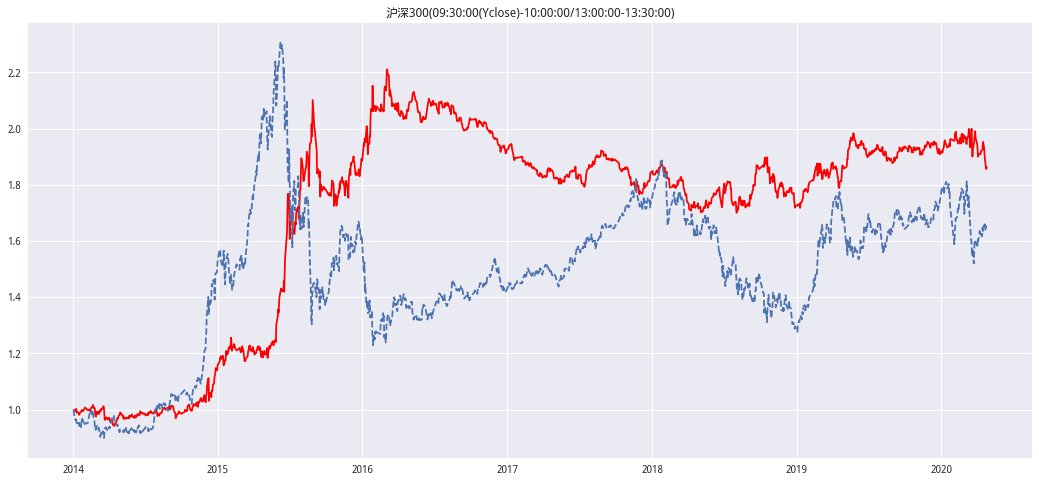

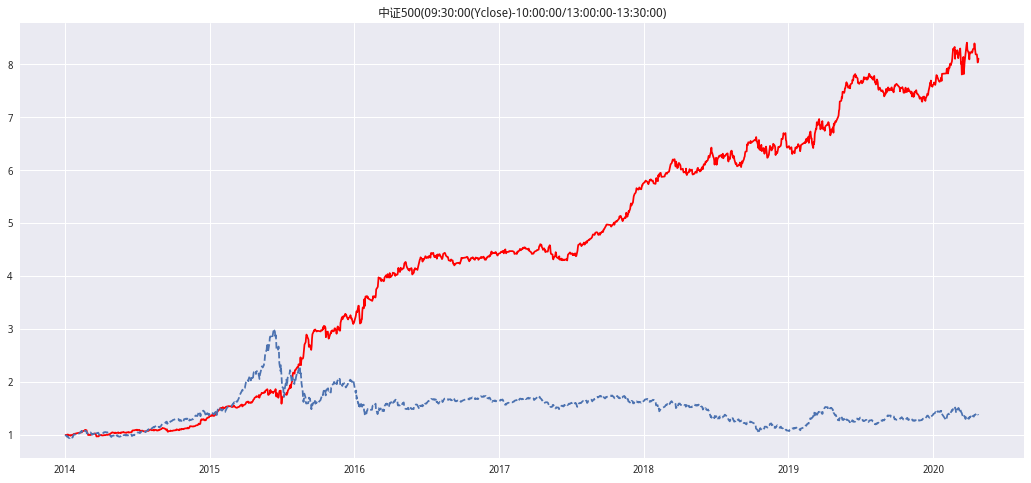

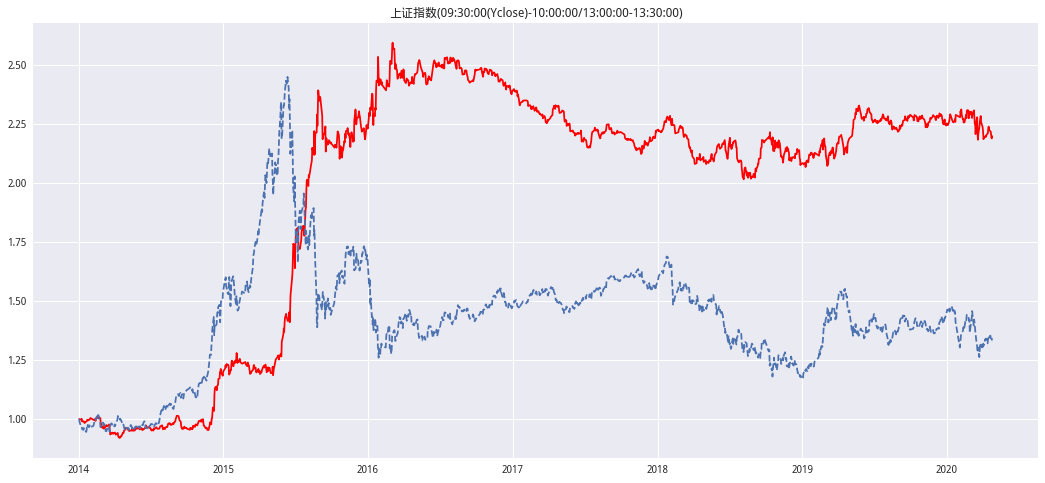

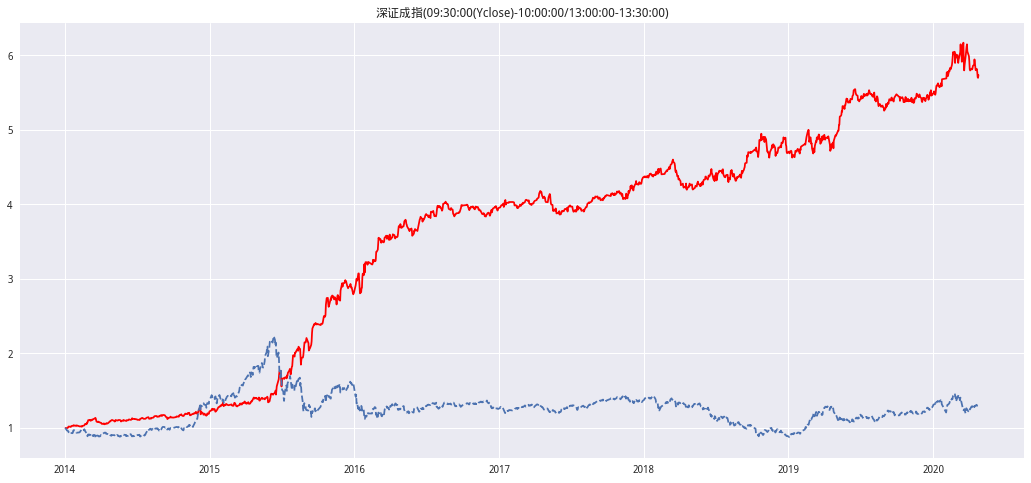

In [9]:
for code in security_list:
    plot_cum(
        data_dict[code][1],
        data_dict[code][0],
        code,
        target=('09:30:00(Yclose)-10:00:00', '13:00:00-13:30:00'))

策略二：若9:30-10:00(yclose)指数涨/跌，14:30-15:00做多/空。日内交易，回测区间 2014.01.01-2020.4.24

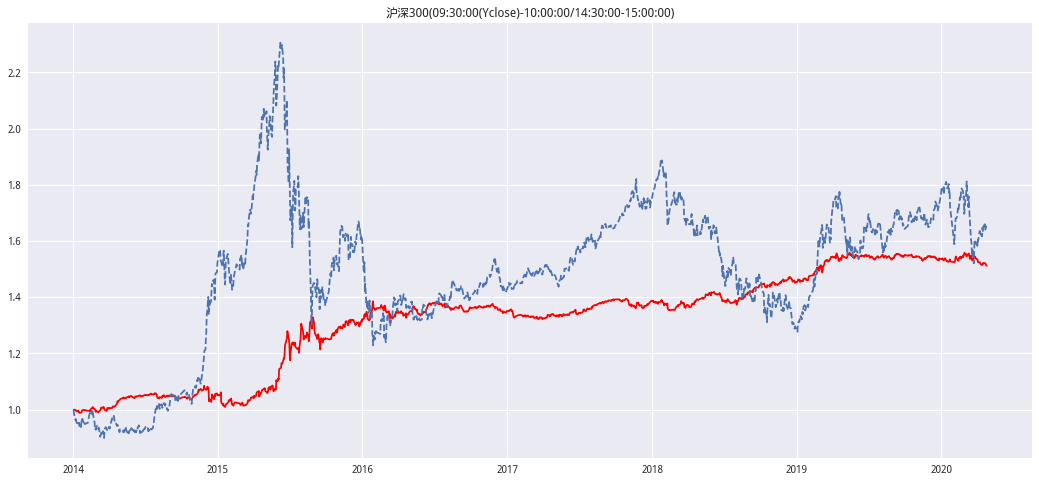

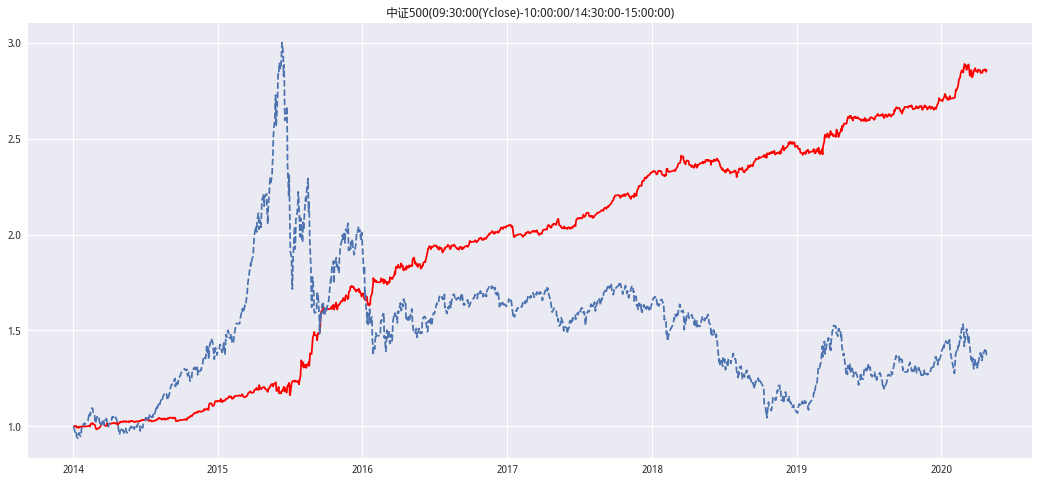

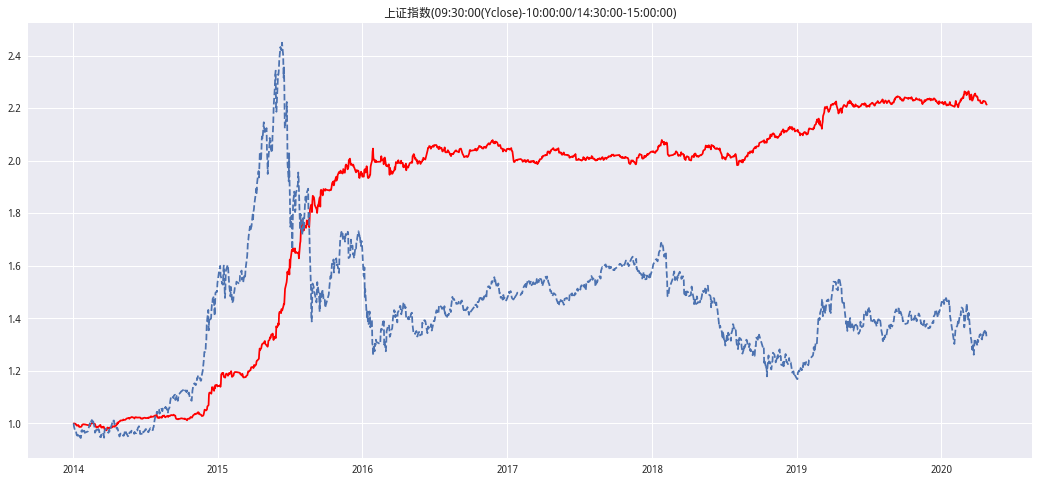

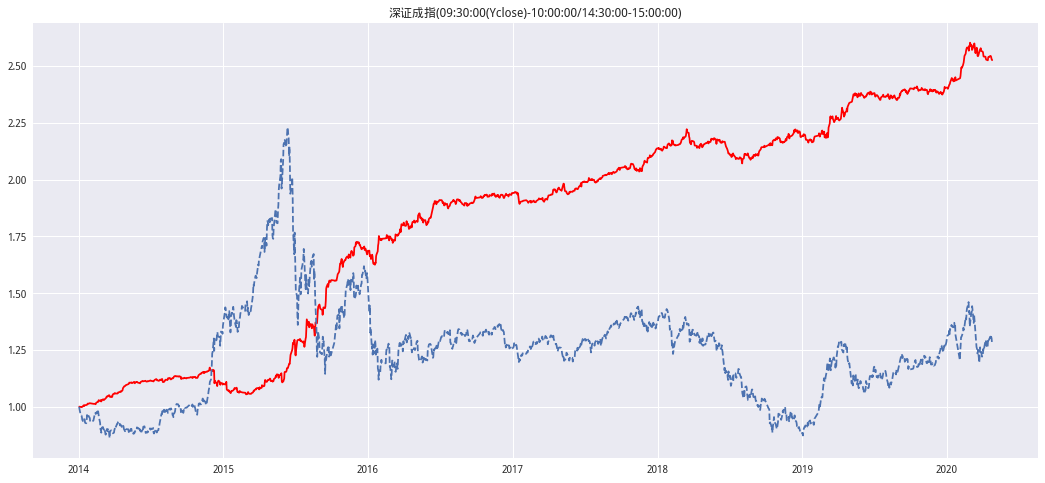

In [10]:
for code in security_list:
    plot_cum(
        data_dict[code][1],
        data_dict[code][0],
        code,
        target=('09:30:00(Yclose)-10:00:00', '14:30:00-15:00:00'))